In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qutip import *

from benchmarks_circuit import (
    cat_state_circuit, gkp_state_circuit, JCH_simulation_circuit_display,JCH_simulation_circuit_unitary,
    binary_knapsack_vqe, binary_knapsack_vqe_circuit, shors_circuit, qft_circuit, state_transfer_CVtoDV,cv_qaoa,cv_qaoa_circuit
)
from features import (
    collect_cvcircuit_metrics, evaluate_quantum_metrics,
)
from shors_runner import *

from custom_gates import bosonic_vqe

import c2qa

## CAT State Circuit

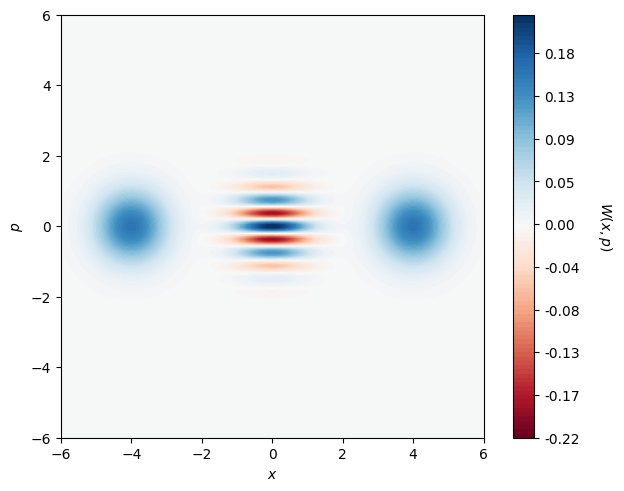

In [2]:
cutoff = 64
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=6, name='qumode')
qbr = QuantumRegister(1)
circuit = c2qa.CVCircuit(qmr, qbr)
circuit = cat_state_circuit(cutoff, circuit, qbr, qmr, alpha=4)
state, _, _ = c2qa.util.simulate(circuit)

fig = c2qa.wigner.plot_wigner(circuit, state)

## GKP Circuit

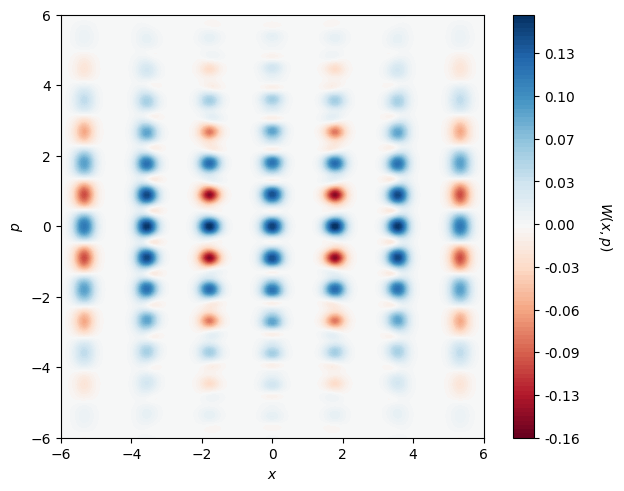

In [13]:
cutoff = 128
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=7, name='qumode')
qbr = QuantumRegister(1)
circuit = c2qa.CVCircuit(qmr, qbr)
circuit = gkp_state_circuit(cutoff, circuit, qbr, qmr,N_rounds=9,r=1.202)
state, _, _ = c2qa.util.simulate(circuit)

fig = c2qa.wigner.plot_wigner(circuit, state)

bq_state = c2qa.wigner.trace_out_qubits(circuit, state)

## State Transfer CV to DV

In [4]:
cutoff = 64
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=6, name='qumode')
qbr = QuantumRegister(4)
cr = ClassicalRegister(4)
circuit = c2qa.CVCircuit(qmr, qbr, cr)
circuit = state_transfer_CVtoDV(cutoff, circuit, qmr, qbr, cr, 4)

In [5]:
state, dv_dist, _ = c2qa.util.simulate(circuit)

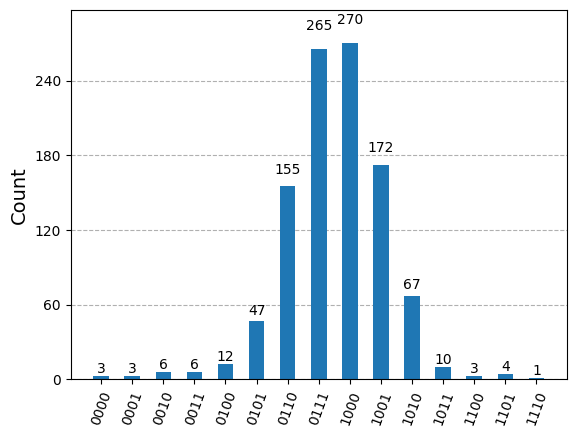

In [6]:
plot_histogram(dv_dist.get_counts())

## CV-DV QFT

In [ ]:
circuit = qft_circuit(16, 1.1, 2, 1, 2)
state, dv_dist, _ = c2qa.util.simulate(circuit)

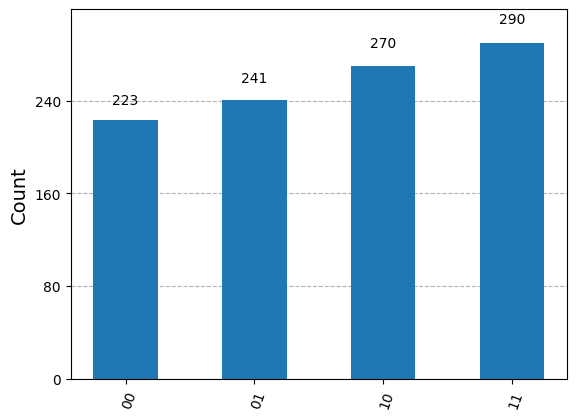

In [24]:
plot_histogram(dv_dist.get_counts())

## CV-DV VQE

In [ ]:
values = [1, 4, 5, 10]
weights = [2.5, 1, 2, 3]
max_weight = 7
l_val = 3

nfocks = [8,8]
ndepth = 5

bkp_fun1, bkp_list1 = bosonic_vqe.binary_knapsack_ham(l_val, values, weights, max_weight)
bkp_list1 = bosonic_vqe.binary_to_pauli_list(bkp_fun1, bkp_list1)
bkp_ham1 = Qobj( bosonic_vqe.qubit_op_to_ham(bkp_list1).full() )

en, Xvec, int_results = binary_knapsack_vqe(bkp_ham1, ndepth, nfocks,  maxiter=120, method='BFGS',
                                    verb=1, threshold=1e-6)


In [26]:
P1 = bosonic_vqe.num_prob_all(Xvec,ndepth,nfocks)

## JCH Simulation

In [27]:
cutoff = 2**2
Nsites = 3
qmr = c2qa.QumodeRegister(Nsites, num_qubits_per_qumode=2)
qbr = QuantumRegister(Nsites)
circuit_template = c2qa.CVCircuit(qmr, qbr)
circuit_template.cv_initialize(2, qmr[0])
U1 = JCH_simulation_circuit_unitary(Nsites, Nqubits=Nsites, cutoff=cutoff,
                                        J=1, omega_r=2*np.pi*2, omega_q=2*np.pi*2,
                                        g=2*np.pi*0.5, tau=0.1)



In [ ]:
qmr = c2qa.QumodeRegister(num_qumodes=3, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
qbr = QuantumRegister(3)
circuit = c2qa.CVCircuit(qmr,qbr)
circuit.cv_initialize(2, qmr[0])

tarray = np.arange(0, 50*0.1, 0.1)
occupancy_list = np.zeros((len(tarray),3))
i = 0
for tau in tarray:
    print('Timestep ' + str(int(i+1)) + '/' + str(len(tarray)))
    circuit.append(U1,qmr[:]+qbr[:])
    state, result, _ = c2qa.util.simulate(circuit)
    occupancy, _ = c2qa.util.stateread(state, 3,3,4, verbose=False,little_endian=False)
    occupancy_list[i,:]=np.array(occupancy[0])
    i = i+1

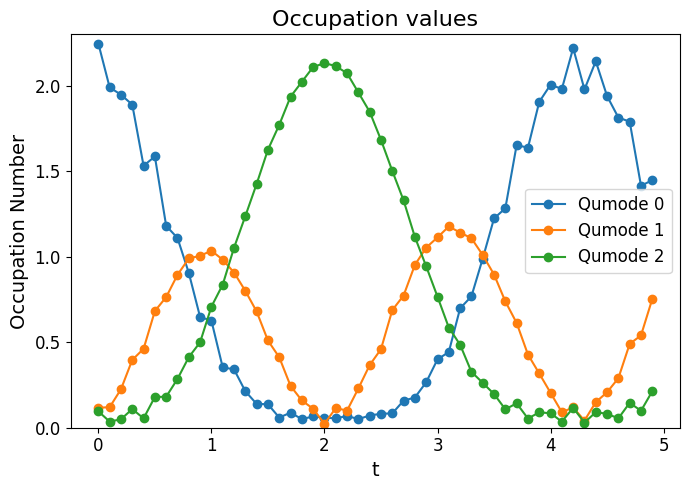

In [29]:
data1 = occupancy_list
time_steps = tarray

plt.figure(figsize=(7, 5))  # slightly increase figure size

plt.plot(time_steps, data1[:, 0], label='Qumode 0', marker='o')
plt.plot(time_steps, data1[:, 1], label='Qumode 1', marker='o')
plt.plot(time_steps, data1[:, 2], label='Qumode 2', marker='o')

plt.title('Occupation values', fontsize=16)      # was 14
plt.xlabel('t', fontsize=14)                     # was 12
plt.ylabel('Occupation Number', fontsize=14)     # was 12
plt.ylim(0, 2.3)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)  # increase legend font size a bit

plt.tight_layout()
plt.show()

## Shor's circuit

In [36]:
settings = [(128, [15, 221, 899, 1001])]  #(cutoff,[numbers to factorise])

Ns = []
probabilities = []
labels = []

for cutoff, numbers in settings:
    for N in numbers:
        write_log(f"\n=== Running for N={N}, cutoff={cutoff} ===")
        success_rate, factors, total_successes, total_shots = estimate_success_probability(
                N=N, m=2, R=15, delta=1.202, cutoff=cutoff, trials=5, shots=1024
        )
        Ns.append(N)
        probabilities.append(success_rate)
        label = ', '.join(map(str, factors)) if factors else "None"
        labels.append(label)

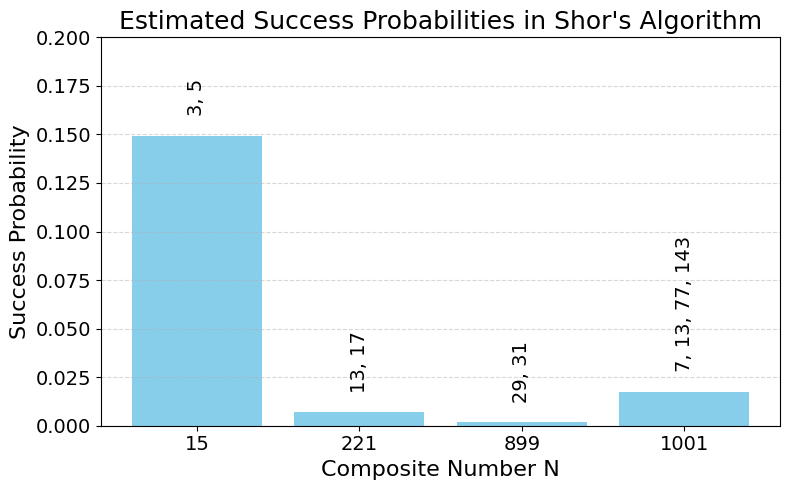

In [40]:
plt.figure(figsize=(8, 5))
bars = plt.bar([str(N) for N in Ns], probabilities, color='skyblue')

# Annotate each bar with its factors (as label)
for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, label,
             ha='center', va='bottom', fontsize=14, rotation=90)

plt.title("Estimated Success Probabilities in Shor's Algorithm", fontsize=18)
plt.xlabel("Composite Number N", fontsize=16)
plt.ylabel("Success Probability", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(0, 0.2)  # y-axis from 0 to slightly above 1
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
